# Problem set 1

In [1]:
import spacy

nlp = spacy.load("en", disable=["ner"])

In [2]:
from zipfile import ZipFile
import re
from tqdm import tqdm
import random

with ZipFile("cases.zip") as zipfile:

    ids = []
    year = {}
    cases = {}
    for name in sorted(zipfile.namelist()):
        m = re.match(r"(\d{4})_(\w*).txt", name)
        id = m.group(2)
        ids.append(id)
        year[id] = int(m.group(1))
        cases[id] = zipfile.open(name).read().decode("utf8")



In [3]:
ids = random.sample(ids, 500)
cases = [cases[id] for id in ids]
year = [year[id] for id in ids]
docs = list(tqdm(nlp.pipe(cases, batch_size=10)))


500it [06:52,  1.21it/s]


In [4]:
import matplotlib.pyplot as plt

plt.title("Number of sentences")
plt.hist([sum(1 for _ in doc.sents) for doc in docs])


(array([282., 133.,  52.,  22.,   4.,   5.,   0.,   1.,   0.,   1.]),
 array([   2. ,  147.5,  293. ,  438.5,  584. ,  729.5,  875. , 1020.5,
        1166. , 1311.5, 1457. ]),
 <a list of 10 Patch objects>)

(array([270., 142.,  51.,  25.,   5.,   3.,   1.,   1.,   1.,   1.]),
 array([1.20000e+01, 3.32530e+03, 6.63860e+03, 9.95190e+03, 1.32652e+04,
        1.65785e+04, 1.98918e+04, 2.32051e+04, 2.65184e+04, 2.98317e+04,
        3.31450e+04]),
 <a list of 10 Patch objects>)

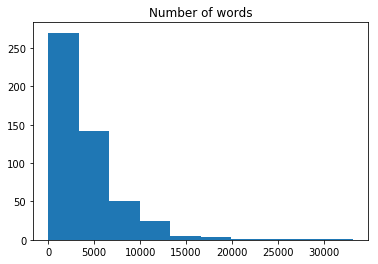

In [5]:
plt.title("Number of words")
plt.hist([sum(1 for _ in doc) for doc in docs])


(array([273., 144.,  49.,  23.,   6.,   1.,   1.,   1.,   1.,   1.]),
 array([4.100000e+01, 1.731560e+04, 3.459020e+04, 5.186480e+04,
        6.913940e+04, 8.641400e+04, 1.036886e+05, 1.209632e+05,
        1.382378e+05, 1.555124e+05, 1.727870e+05]),
 <a list of 10 Patch objects>)

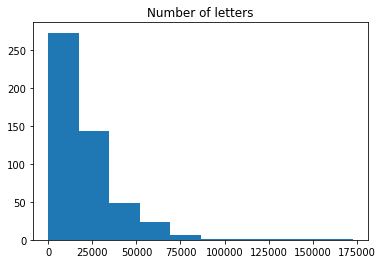

In [6]:
plt.title("Number of letters")
plt.hist([sum(1 for _ in doc.text) for doc in docs])


(array([277., 149.,  47.,  17.,   5.,   2.,   1.,   1.,   0.,   1.]),
 array([   0. ,  635.6, 1271.2, 1906.8, 2542.4, 3178. , 3813.6, 4449.2,
        5084.8, 5720.4, 6356. ]),
 <a list of 10 Patch objects>)

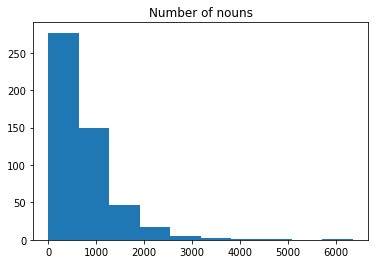

In [7]:
plt.title("Number of nouns")
plt.hist([sum(tok.pos_ == "NOUN" for tok in doc) for doc in docs])


(array([254., 153.,  56.,  23.,   8.,   2.,   1.,   1.,   1.,   1.]),
 array([1.0000e+00, 4.0510e+02, 8.0920e+02, 1.2133e+03, 1.6174e+03,
        2.0215e+03, 2.4256e+03, 2.8297e+03, 3.2338e+03, 3.6379e+03,
        4.0420e+03]),
 <a list of 10 Patch objects>)

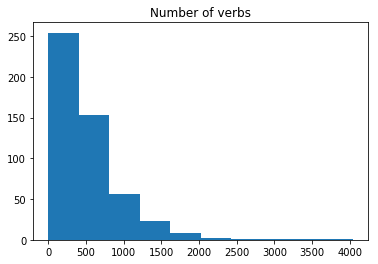

In [8]:
plt.title("Number of verbs")
plt.hist([sum(tok.pos_ == "VERB" for tok in doc) for doc in docs])


(array([324., 113.,  43.,  10.,   6.,   1.,   0.,   2.,   0.,   1.]),
 array([   0. ,  253.3,  506.6,  759.9, 1013.2, 1266.5, 1519.8, 1773.1,
        2026.4, 2279.7, 2533. ]),
 <a list of 10 Patch objects>)

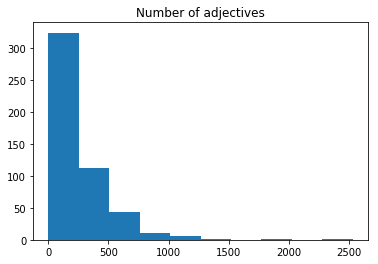

In [9]:
plt.title("Number of adjectives")
plt.hist([sum(tok.pos_ == "ADJ" for tok in doc) for doc in docs])


In [10]:
from operator import itemgetter


def normalize(doc):
    ans = []
    for tok in doc:
        if tok.is_stop or tok.is_punct or tok.is_space:
            continue
        norm = tok.lemma_
        if norm:
            ans.append((norm, tok.pos_))
    return ans


def make_trigrams(words):
    return list(zip(words, words[1:], words[2:]))


def filter_for_nouns(trigrams):
    return [
        tuple(map(itemgetter(0), tri))
        for tri in trigrams
        if tri[-1][1] == "NOUN"
    ]


trigrams = [filter_for_nouns(make_trigrams(normalize(doc))) for doc in docs]

In [11]:
from collections import Counter
import itertools
from functools import partial

most_common_trigrams = [
    t for t, _ in Counter(itertools.chain.from_iterable(trigrams)).most_common(1000)
]


In [12]:
def make_feature(most_common_trigrams, trigrams):
    c = Counter(trigrams)
    return list(map(c.__getitem__, most_common_trigrams))



In [13]:

import pandas as pd
import numpy as np

X = np.array(list(list(map(partial(make_feature, most_common_trigrams), trigrams))))
X = X / X.std(axis=0)


In [14]:

df = pd.DataFrame({"caseid": ids, **dict(zip(most_common_trigrams, X.T))}).merge(
    pd.read_csv("case_reversed.csv"), on="caseid"
)
y = df.case_reversed.values


In [15]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
model = LogisticRegression(solver="liblinear")

model.fit(X_train, y_train)

print(f"Training accuracy {model.score(X_train, y_train)}")
print(f"Training F1 {model.score(X_train, y_train)}")
print(f"Test accuracy {model.score(X_test, y_test)}")
print(f"Test F1 {model.score(X_test, y_test)}")



Training accuracy 0.9825
Training F1 0.9825
Test accuracy 0.59
Test F1 0.59


In [16]:

model = GridSearchCV(
    LogisticRegression(solver="liblinear"),
    {"penalty": ("l1", "l2"), "C": [10 ** i for i in range(-5, 5)]},
    cv=5,
    iid=False,
)
model.fit(X, y)

print(f"Best model got {model.best_score_} accuracy with params {model.best_params_}")


Best model got 0.606004200420042 accuracy with params {'C': 1e-05, 'penalty': 'l2'}


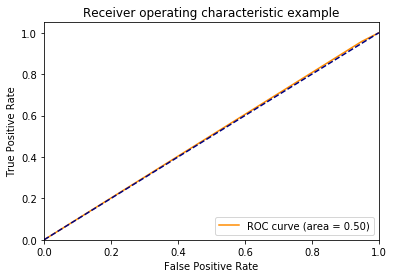

In [17]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_predict

scores = cross_val_predict(model.best_estimator_, X, y, cv=5)
fpr, tpr, thresholds = roc_curve(y, scores)

plt.plot(
    fpr,
    tpr,
    color="darkorange",
    label=f"ROC curve (area = {roc_auc_score(y, scores):.02f})",
)
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()



In [18]:
from operator import attrgetter

sentences = list(
    map(
        attrgetter("text"),
        itertools.chain.from_iterable(map(attrgetter("sents"), docs)),
    )
)

sentences = random.sample(sentences, 10000)

In [19]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

scores = list(map(itemgetter("compound"), map(sid.polarity_scores, sentences)))

lowest = np.argsort(scores)[:10]
print("lowest compound scores:")
print(*map(sentences.__getitem__, lowest), sep="\n")
print("highest compound scores:")
highest = np.argsort(scores)[-10:]
print(*map(sentences.__getitem__, highest), sep="\n")


lowest compound scores:
Quite similar to the wrongful death statute of Oklahoma, supra , at the time of the airplane crash referred to herein, it was provided by statute in Missouri that when the death of a person was caused by a wrongful act, neglect, or default of another, and such act, neglect, or default was such as would, if death had not ensued, have entitled the party injured to maintain an action and recover damages therefor, an action for damages might be maintained, notwithstanding the death of the person injured.

Both appellants were charged with conspiracy to commit offenses against the United States, in violation of 18 U.S.C. 371 (count I); wire fraud, in violation of 18 U.S.C. 1343 (count II); interstate transportation of stolen property, in violation of 18 U.S.C. 2314 (count III); misapplication of funds, in violation of 18 U.S.C. 657 (count IV); false statements, in violation of 18 U.S.C. 1006 (count VI and VIII).

While it would be trite in ordinary circumstances to d

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(sentences)


In [21]:
from sklearn.metrics.pairwise import cosine_similarity

similarities = cosine_similarity(X)

aux = np.unravel_index(np.argsort(similarities.ravel()), similarities.shape)


In [22]:
aux

(array([4859, 5636, 5636, ..., 2017, 9012, 1404]),
 array([8761, 1401, 1404, ..., 6304, 1404, 9012]))

In [23]:
similarities[aux[0], aux[1]]

array([0., 0., 0., ..., 1., 1., 1.])

In [25]:

print("Dissimilar sentences")
for a, b in zip(aux[0][:5], aux[1][:5]):
    print(sentences[a])
    print(sentences[b])
    print('---')

print("Similar sentences")
c = 5
i = 0
while c:
    i += 1
    a, b = aux[0][-i], aux[1][-i]
    if sentences[a] == sentences[b]:
        continue
    print(sentences[a])
    print(sentences[b])
    print('---')
    c -= 1


Dissimilar sentences
Although Myers and Humphrey's Executor both concerned officers who were appointed by the President, whereas the independent counsel was appointed by the Special Court, we think the Supreme Court's analysis of the President's removal power in both cases applies to an officer who, like the independent counsel, is charged with an indisputably executive function.

Id .

---
In this context the word "review" is a misnomer; the Special Court is basically a "superior and revising agency" with a veto over the Attorney General's decision.

J.A.
230.

---
In this context the word "review" is a misnomer; the Special Court is basically a "superior and revising agency" with a veto over the Attorney General's decision.

1602 , 16 L.Ed.2d
---
In this context the word "review" is a misnomer; the Special Court is basically a "superior and revising agency" with a veto over the Attorney General's decision.

Res judicata generally applies to bind absent class members except where to d